## 1. Setup & Imports

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Metrics & visualization
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    mean_absolute_error, mean_squared_error, r2_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create models directory
MODELS_DIR = Path('models')
MODELS_DIR.mkdir(exist_ok=True)

print("✅ Setup complete!")

Using device: cuda
✅ Setup complete!


## 2. Load Preprocessed Data

In [2]:
DATA_DIR = Path('processed_data')

print("Loading preprocessed datasets...\n")

# Load features
X_train = np.load(DATA_DIR / 'delay_X_train.npy')
X_val = np.load(DATA_DIR / 'delay_X_val.npy')
X_test = np.load(DATA_DIR / 'delay_X_test.npy')

# Load targets - Binary
y_binary_train = np.load(DATA_DIR / 'delay_y_binary_train.npy')
y_binary_val = np.load(DATA_DIR / 'delay_y_binary_val.npy')
y_binary_test = np.load(DATA_DIR / 'delay_y_binary_test.npy')

# Load targets - Multi-class
y_multi_train = np.load(DATA_DIR / 'delay_y_multi_train.npy')
y_multi_val = np.load(DATA_DIR / 'delay_y_multi_val.npy')
y_multi_test = np.load(DATA_DIR / 'delay_y_multi_test.npy')

# Load targets - Regression
y_reg_train = np.load(DATA_DIR / 'delay_y_reg_train.npy')
y_reg_val = np.load(DATA_DIR / 'delay_y_reg_val.npy')
y_reg_test = np.load(DATA_DIR / 'delay_y_reg_test.npy')

# Load metadata
with open(DATA_DIR / 'delay_feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)

with open(DATA_DIR / 'delay_encoders.pkl', 'rb') as f:
    encoders = pickle.load(f)

num_classes = len(encoders['cause'].classes_)

print(f"✅ Data loaded successfully!")
print(f"\n📊 Dataset Shapes:")
print(f"  Train: {X_train.shape}")
print(f"  Val:   {X_val.shape}")
print(f"  Test:  {X_test.shape}")
print(f"\n🎯 Task Information:")
print(f"  Binary classes: 2 (delayed/on-time)")
print(f"  Multi-classes: {num_classes} → {encoders['cause'].classes_.tolist()}")
print(f"  Features: {len(feature_names)}")

Loading preprocessed datasets...

✅ Data loaded successfully!

📊 Dataset Shapes:
  Train: (120166, 16)
  Val:   (25750, 16)
  Test:  (25750, 16)

🎯 Task Information:
  Binary classes: 2 (delayed/on-time)
  Multi-classes: 6 → ['carrier', 'late_aircraft', 'nas', 'none', 'security', 'weather']
  Features: 16


## 3. Create PyTorch DataLoaders

In [3]:
# Convert to PyTorch tensors
def create_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=512):
    # Convert to tensors
    X_train_t = torch.FloatTensor(X_train)
    y_train_t = torch.LongTensor(y_train)
    X_val_t = torch.FloatTensor(X_val)
    y_val_t = torch.LongTensor(y_val)
    X_test_t = torch.FloatTensor(X_test)
    y_test_t = torch.LongTensor(y_test)
    
    # Create datasets
    train_dataset = TensorDataset(X_train_t, y_train_t)
    val_dataset = TensorDataset(X_val_t, y_val_t)
    test_dataset = TensorDataset(X_test_t, y_test_t)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

# Create dataloaders for each task
binary_loaders = create_dataloaders(X_train, y_binary_train, X_val, y_binary_val, X_test, y_binary_test)
multi_loaders = create_dataloaders(X_train, y_multi_train, X_val, y_multi_val, X_test, y_multi_test)

# Regression requires FloatTensor for targets
X_train_t = torch.FloatTensor(X_train)
y_reg_train_t = torch.FloatTensor(y_reg_train).unsqueeze(1)
X_val_t = torch.FloatTensor(X_val)
y_reg_val_t = torch.FloatTensor(y_reg_val).unsqueeze(1)
X_test_t = torch.FloatTensor(X_test)
y_reg_test_t = torch.FloatTensor(y_reg_test).unsqueeze(1)

reg_train_loader = DataLoader(TensorDataset(X_train_t, y_reg_train_t), batch_size=512, shuffle=True)
reg_val_loader = DataLoader(TensorDataset(X_val_t, y_reg_val_t), batch_size=512, shuffle=False)
reg_test_loader = DataLoader(TensorDataset(X_test_t, y_reg_test_t), batch_size=512, shuffle=False)

print("✅ DataLoaders created!")

✅ DataLoaders created!


## 4. Define Neural Network Architecture

In [4]:
class DelayPredictor(nn.Module):
    """Feedforward Neural Network for Delay Prediction"""
    
    def __init__(self, input_dim, output_dim, task='binary', hidden_dims=[128, 64, 32], dropout=0.3):
        super(DelayPredictor, self).__init__()
        self.task = task
        
        # Build layers dynamically
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        
        self.feature_extractor = nn.Sequential(*layers)
        self.output_layer = nn.Linear(prev_dim, output_dim)
    
    def forward(self, x):
        features = self.feature_extractor(x)
        output = self.output_layer(features)
        return output

# Model parameters
input_dim = X_train.shape[1]
hidden_dims = [128, 64, 32]
dropout = 0.3

print(f"✅ Model architecture defined:")
print(f"  Input: {input_dim} features")
print(f"  Hidden: {hidden_dims}")
print(f"  Dropout: {dropout}")

✅ Model architecture defined:
  Input: 16 features
  Hidden: [128, 64, 32]
  Dropout: 0.3


## 5. Training Utilities

In [5]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def evaluate(model, val_loader, criterion, device, task='classification'):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()
            
            if task == 'classification':
                preds = outputs.argmax(dim=1)
            else:  # regression
                preds = outputs
            
            all_preds.append(preds.cpu().numpy())
            all_targets.append(batch_y.cpu().numpy())
    
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    
    return total_loss / len(val_loader), all_preds, all_targets

def train_model(model, train_loader, val_loader, criterion, optimizer, 
                num_epochs, device, task='classification', early_stopping_patience=10):
    """Full training loop with early stopping"""
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, _, _ = evaluate(model, val_loader, criterion, device, task)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        # Print progress
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"\n⚠️ Early stopping at epoch {epoch+1}")
                break
    
    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return history

print("✅ Training utilities ready!")

✅ Training utilities ready!


## 6. Task 1: Binary Classification (Delayed vs On-time)

In [6]:
print("=" * 80)
print("TASK 1: BINARY CLASSIFICATION (Delayed vs On-time)")
print("=" * 80)

# Create model
binary_model = DelayPredictor(
    input_dim=input_dim,
    output_dim=2,  # Binary classification
    task='binary',
    hidden_dims=hidden_dims,
    dropout=dropout
).to(device)

# Loss and optimizer
binary_criterion = nn.CrossEntropyLoss()
binary_optimizer = optim.Adam(binary_model.parameters(), lr=0.001, weight_decay=1e-5)

print(f"\n🧠 Model: {sum(p.numel() for p in binary_model.parameters()):,} parameters")
print("\n🚀 Training started...\n")

# Train
binary_history = train_model(
    model=binary_model,
    train_loader=binary_loaders[0],
    val_loader=binary_loaders[1],
    criterion=binary_criterion,
    optimizer=binary_optimizer,
    num_epochs=50,
    device=device,
    task='classification',
    early_stopping_patience=10
)

print("\n✅ Training complete!")

TASK 1: BINARY CLASSIFICATION (Delayed vs On-time)

🧠 Model: 13,026 parameters

🚀 Training started...


🧠 Model: 13,026 parameters

🚀 Training started...

Epoch [1/50] - Train Loss: 0.1766, Val Loss: 0.0569
Epoch [1/50] - Train Loss: 0.1766, Val Loss: 0.0569
Epoch [5/50] - Train Loss: 0.0220, Val Loss: 0.0101
Epoch [5/50] - Train Loss: 0.0220, Val Loss: 0.0101
Epoch [10/50] - Train Loss: 0.0121, Val Loss: 0.0023
Epoch [10/50] - Train Loss: 0.0121, Val Loss: 0.0023
Epoch [15/50] - Train Loss: 0.0103, Val Loss: 0.0017
Epoch [15/50] - Train Loss: 0.0103, Val Loss: 0.0017
Epoch [20/50] - Train Loss: 0.0082, Val Loss: 0.0047
Epoch [20/50] - Train Loss: 0.0082, Val Loss: 0.0047
Epoch [25/50] - Train Loss: 0.0076, Val Loss: 0.0013
Epoch [25/50] - Train Loss: 0.0076, Val Loss: 0.0013
Epoch [30/50] - Train Loss: 0.0063, Val Loss: 0.0018
Epoch [30/50] - Train Loss: 0.0063, Val Loss: 0.0018

⚠️ Early stopping at epoch 31

✅ Training complete!

⚠️ Early stopping at epoch 31

✅ Training complete!


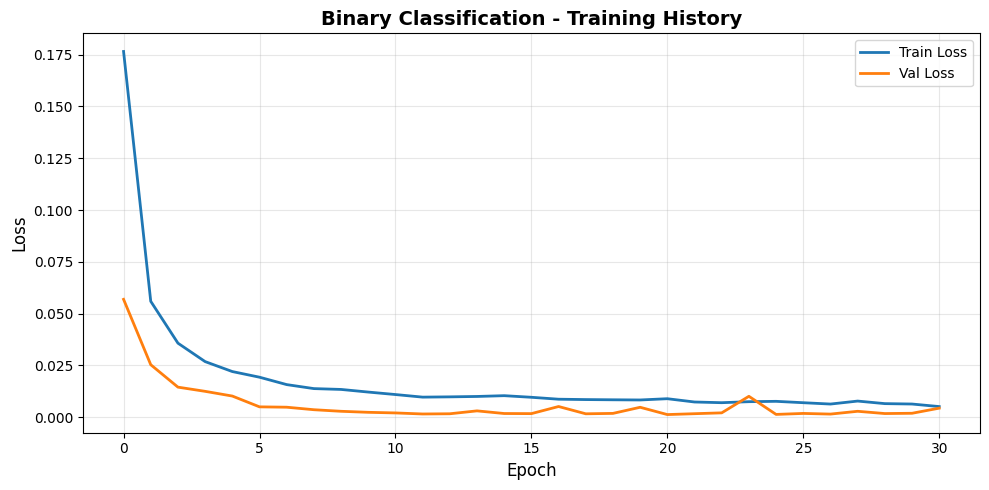

In [7]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(binary_history['train_loss'], label='Train Loss', linewidth=2)
plt.plot(binary_history['val_loss'], label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Binary Classification - Training History', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
# Evaluate on test set
test_loss, test_preds, test_targets = evaluate(
    binary_model, binary_loaders[2], binary_criterion, device, task='classification'
)

# Calculate metrics
accuracy = accuracy_score(test_targets, test_preds)
precision = precision_score(test_targets, test_preds)
recall = recall_score(test_targets, test_preds)
f1 = f1_score(test_targets, test_preds)

print("\n📊 BINARY CLASSIFICATION RESULTS:")
print("=" * 50)
print(f"Test Loss:  {test_loss:.4f}")
print(f"Accuracy:   {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision:  {precision:.4f}")
print(f"Recall:     {recall:.4f}")
print(f"F1-Score:   {f1:.4f}")

print("\n📋 Classification Report:")
print(classification_report(test_targets, test_preds, target_names=['On-time', 'Delayed']))


📊 BINARY CLASSIFICATION RESULTS:
Test Loss:  0.0017
Accuracy:   0.9995 (99.95%)
Precision:  1.0000
Recall:     0.9994
F1-Score:   0.9997

📋 Classification Report:
              precision    recall  f1-score   support

     On-time       0.99      1.00      0.99      1121
     Delayed       1.00      1.00      1.00     24629

    accuracy                           1.00     25750
   macro avg       0.99      1.00      1.00     25750
weighted avg       1.00      1.00      1.00     25750



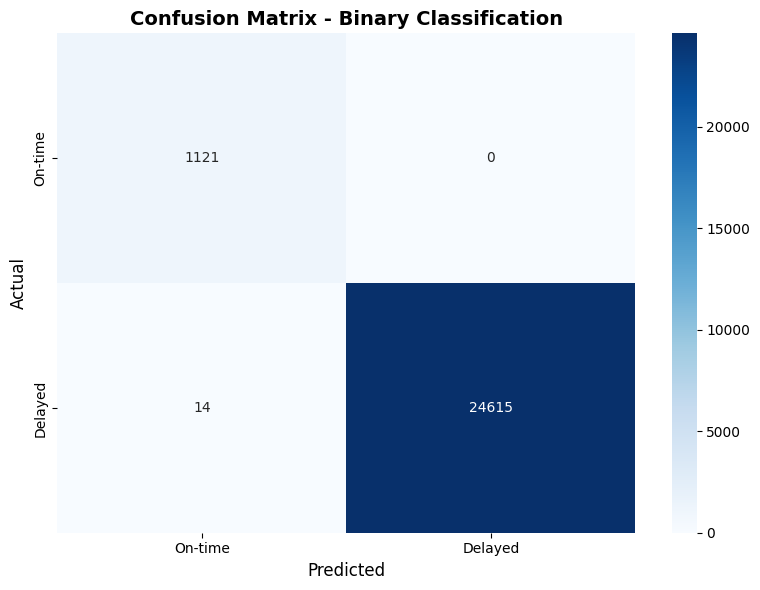


💾 Model saved: models/delay_binary_model.pth


In [9]:
# Confusion matrix
cm = confusion_matrix(test_targets, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['On-time', 'Delayed'],
            yticklabels=['On-time', 'Delayed'])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix - Binary Classification', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Save model
torch.save(binary_model.state_dict(), MODELS_DIR / 'delay_binary_model.pth')
print("\n💾 Model saved: models/delay_binary_model.pth")

## 7. Task 2: Multi-class Classification (Delay Cause)

In [10]:
print("\n" + "=" * 80)
print("TASK 2: MULTI-CLASS CLASSIFICATION (Delay Cause)")
print("=" * 80)

# Create model
multi_model = DelayPredictor(
    input_dim=input_dim,
    output_dim=num_classes,
    task='multiclass',
    hidden_dims=[256, 128, 64],  # Larger for multi-class
    dropout=0.4
).to(device)

# Loss and optimizer
multi_criterion = nn.CrossEntropyLoss()
multi_optimizer = optim.Adam(multi_model.parameters(), lr=0.001, weight_decay=1e-5)

print(f"\n🧠 Model: {sum(p.numel() for p in multi_model.parameters()):,} parameters")
print(f"Classes: {encoders['cause'].classes_.tolist()}")
print("\n🚀 Training started...\n")

# Train
multi_history = train_model(
    model=multi_model,
    train_loader=multi_loaders[0],
    val_loader=multi_loaders[1],
    criterion=multi_criterion,
    optimizer=multi_optimizer,
    num_epochs=50,
    device=device,
    task='classification',
    early_stopping_patience=10
)

print("\n✅ Training complete!")


TASK 2: MULTI-CLASS CLASSIFICATION (Delay Cause)

🧠 Model: 46,790 parameters
Classes: ['carrier', 'late_aircraft', 'nas', 'none', 'security', 'weather']

🚀 Training started...

Epoch [1/50] - Train Loss: 1.1230, Val Loss: 0.8847
Epoch [1/50] - Train Loss: 1.1230, Val Loss: 0.8847
Epoch [5/50] - Train Loss: 0.3561, Val Loss: 0.1884
Epoch [5/50] - Train Loss: 0.3561, Val Loss: 0.1884
Epoch [10/50] - Train Loss: 0.2591, Val Loss: 0.1232
Epoch [10/50] - Train Loss: 0.2591, Val Loss: 0.1232
Epoch [15/50] - Train Loss: 0.2395, Val Loss: 0.1003
Epoch [15/50] - Train Loss: 0.2395, Val Loss: 0.1003
Epoch [20/50] - Train Loss: 0.2268, Val Loss: 0.0971
Epoch [20/50] - Train Loss: 0.2268, Val Loss: 0.0971
Epoch [25/50] - Train Loss: 0.2149, Val Loss: 0.0919
Epoch [25/50] - Train Loss: 0.2149, Val Loss: 0.0919
Epoch [30/50] - Train Loss: 0.2062, Val Loss: 0.0853
Epoch [30/50] - Train Loss: 0.2062, Val Loss: 0.0853
Epoch [35/50] - Train Loss: 0.1909, Val Loss: 0.0744
Epoch [35/50] - Train Loss: 0.1

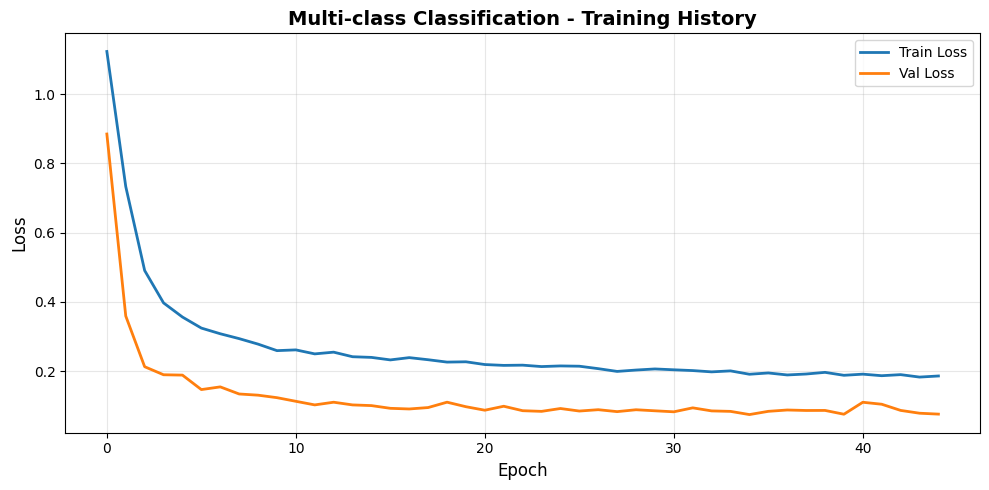

In [11]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(multi_history['train_loss'], label='Train Loss', linewidth=2)
plt.plot(multi_history['val_loss'], label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Multi-class Classification - Training History', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
# Evaluate on test set
test_loss, test_preds, test_targets = evaluate(
    multi_model, multi_loaders[2], multi_criterion, device, task='classification'
)

# Calculate metrics
accuracy = accuracy_score(test_targets, test_preds)
precision = precision_score(test_targets, test_preds, average='weighted')
recall = recall_score(test_targets, test_preds, average='weighted')
f1 = f1_score(test_targets, test_preds, average='weighted')

print("\n📊 MULTI-CLASS CLASSIFICATION RESULTS:")
print("=" * 50)
print(f"Test Loss:  {test_loss:.4f}")
print(f"Accuracy:   {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision:  {precision:.4f}")
print(f"Recall:     {recall:.4f}")
print(f"F1-Score:   {f1:.4f}")

print("\n📋 Classification Report:")
print(classification_report(test_targets, test_preds, target_names=encoders['cause'].classes_))


📊 MULTI-CLASS CLASSIFICATION RESULTS:
Test Loss:  0.0816
Accuracy:   0.9697 (96.97%)
Precision:  0.9698
Recall:     0.9697
F1-Score:   0.9693

📋 Classification Report:
               precision    recall  f1-score   support

      carrier       0.95      0.99      0.97      8632
late_aircraft       0.99      0.97      0.98     11297
          nas       0.96      0.96      0.96      4489
         none       1.00      1.00      1.00      1121
     security       0.00      0.00      0.00         4
      weather       0.88      0.57      0.69       207

     accuracy                           0.97     25750
    macro avg       0.80      0.75      0.77     25750
 weighted avg       0.97      0.97      0.97     25750



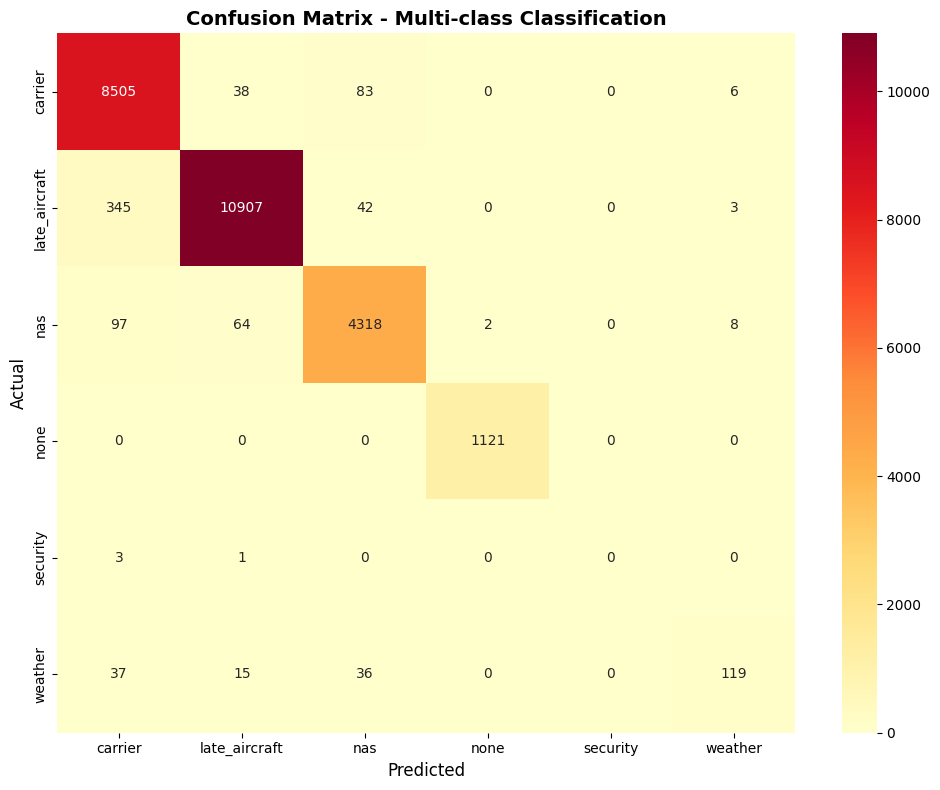


💾 Model saved: models/delay_multiclass_model.pth


In [13]:
# Confusion matrix
cm = confusion_matrix(test_targets, test_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=encoders['cause'].classes_,
            yticklabels=encoders['cause'].classes_)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix - Multi-class Classification', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Save model
torch.save(multi_model.state_dict(), MODELS_DIR / 'delay_multiclass_model.pth')
print("\n💾 Model saved: models/delay_multiclass_model.pth")

## 8. Task 3: Regression (Delay Duration)

In [14]:
print("\n" + "=" * 80)
print("TASK 3: REGRESSION (Delay Duration in Minutes)")
print("=" * 80)

# Create model
reg_model = DelayPredictor(
    input_dim=input_dim,
    output_dim=1,  # Regression - single output
    task='regression',
    hidden_dims=hidden_dims,
    dropout=dropout
).to(device)

# Loss and optimizer
reg_criterion = nn.MSELoss()
reg_optimizer = optim.Adam(reg_model.parameters(), lr=0.001, weight_decay=1e-5)

print(f"\n🧠 Model: {sum(p.numel() for p in reg_model.parameters()):,} parameters")
print("\n🚀 Training started...\n")

# Train
reg_history = train_model(
    model=reg_model,
    train_loader=reg_train_loader,
    val_loader=reg_val_loader,
    criterion=reg_criterion,
    optimizer=reg_optimizer,
    num_epochs=50,
    device=device,
    task='regression',
    early_stopping_patience=10
)

print("\n✅ Training complete!")


TASK 3: REGRESSION (Delay Duration in Minutes)

🧠 Model: 12,993 parameters

🚀 Training started...

Epoch [1/50] - Train Loss: 167879495.7957, Val Loss: 191588122.7843
Epoch [1/50] - Train Loss: 167879495.7957, Val Loss: 191588122.7843
Epoch [5/50] - Train Loss: 166176067.1489, Val Loss: 189253301.3725
Epoch [5/50] - Train Loss: 166176067.1489, Val Loss: 189253301.3725
Epoch [10/50] - Train Loss: 160901621.8383, Val Loss: 182826768.6912
Epoch [10/50] - Train Loss: 160901621.8383, Val Loss: 182826768.6912
Epoch [15/50] - Train Loss: 153837151.3702, Val Loss: 175454242.8873
Epoch [15/50] - Train Loss: 153837151.3702, Val Loss: 175454242.8873
Epoch [20/50] - Train Loss: 145279913.9745, Val Loss: 164925683.3578
Epoch [20/50] - Train Loss: 145279913.9745, Val Loss: 164925683.3578
Epoch [25/50] - Train Loss: 135563582.0681, Val Loss: 155332575.1961
Epoch [25/50] - Train Loss: 135563582.0681, Val Loss: 155332575.1961
Epoch [30/50] - Train Loss: 125426596.0000, Val Loss: 143975147.0637
Epoch [

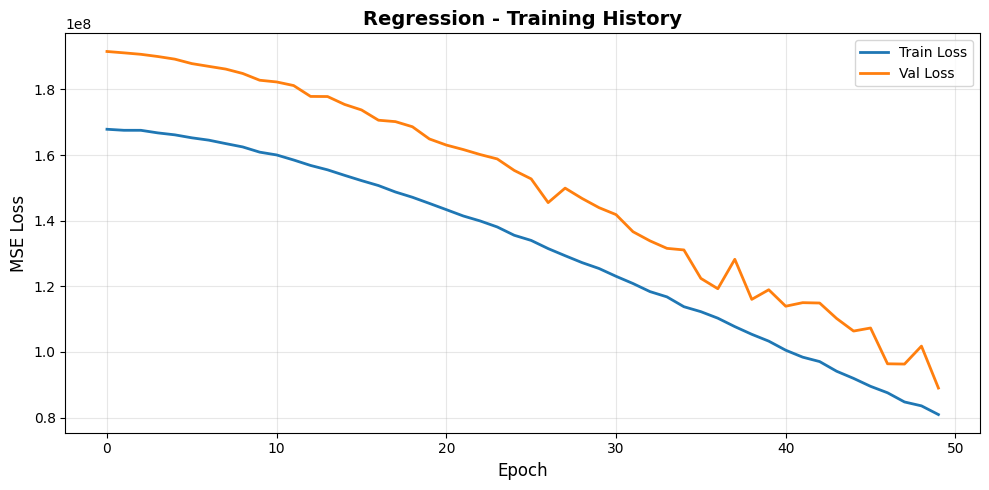

In [15]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(reg_history['train_loss'], label='Train Loss', linewidth=2)
plt.plot(reg_history['val_loss'], label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('Regression - Training History', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [16]:
# Evaluate on test set
test_loss, test_preds, test_targets = evaluate(
    reg_model, reg_test_loader, reg_criterion, device, task='regression'
)

# Flatten predictions
test_preds = test_preds.flatten()
test_targets = test_targets.flatten()

# Calculate metrics
mae = mean_absolute_error(test_targets, test_preds)
mse = mean_squared_error(test_targets, test_preds)
rmse = np.sqrt(mse)
r2 = r2_score(test_targets, test_preds)

print("\n📊 REGRESSION RESULTS:")
print("=" * 50)
print(f"MAE (Mean Absolute Error):  {mae:.2f} minutes")
print(f"MSE (Mean Squared Error):   {mse:.2f}")
print(f"RMSE (Root Mean Sq Error):  {rmse:.2f} minutes")
print(f"R² Score:                   {r2:.4f}")


📊 REGRESSION RESULTS:
MAE (Mean Absolute Error):  3129.93 minutes
MSE (Mean Squared Error):   51750724.00
RMSE (Root Mean Sq Error):  7193.80 minutes
R² Score:                   0.6778


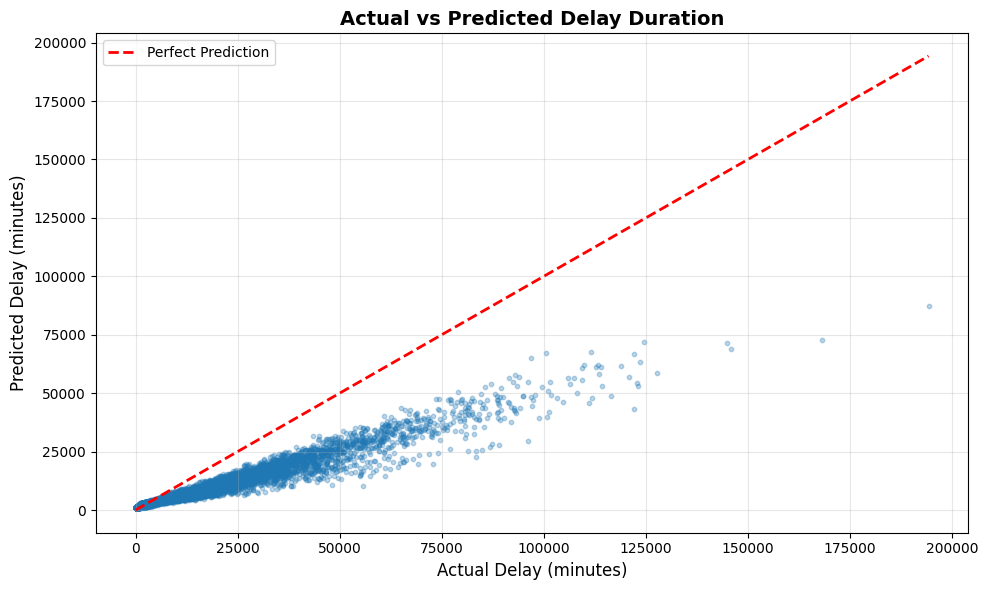

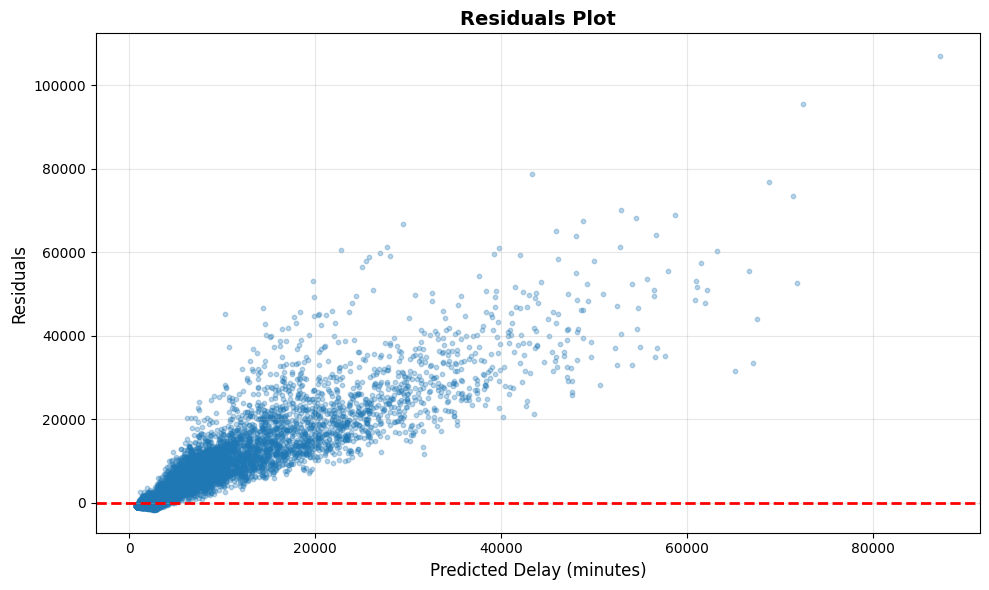


💾 Model saved: models/delay_regression_model.pth


In [17]:
# Actual vs Predicted plot
plt.figure(figsize=(10, 6))
plt.scatter(test_targets, test_preds, alpha=0.3, s=10)
plt.plot([test_targets.min(), test_targets.max()], 
         [test_targets.min(), test_targets.max()], 
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Delay (minutes)', fontsize=12)
plt.ylabel('Predicted Delay (minutes)', fontsize=12)
plt.title('Actual vs Predicted Delay Duration', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Residuals plot
residuals = test_targets - test_preds
plt.figure(figsize=(10, 6))
plt.scatter(test_preds, residuals, alpha=0.3, s=10)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Delay (minutes)', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Residuals Plot', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Save model
torch.save(reg_model.state_dict(), MODELS_DIR / 'delay_regression_model.pth')
print("\n💾 Model saved: models/delay_regression_model.pth")

## 9. Summary & Next Steps

In [18]:
print("\n" + "=" * 80)
print("✅ ALL TASKS COMPLETE!")
print("=" * 80)

print("\n📊 Final Results Summary:")

# Re-evaluate binary classification for summary
_, binary_preds_summary, binary_targets_summary = evaluate(binary_model, binary_loaders[2], binary_criterion, device, 'classification')
print("\n1. BINARY CLASSIFICATION (Delayed vs On-time)")
print(f"   Accuracy: {accuracy_score(binary_targets_summary, binary_preds_summary)*100:.2f}%")

# Re-evaluate multi-class for summary
_, multi_preds, multi_targets = evaluate(multi_model, multi_loaders[2], multi_criterion, device, 'classification')
print("\n2. MULTI-CLASS CLASSIFICATION (Delay Cause)")
print(f"   Accuracy: {accuracy_score(multi_targets, multi_preds)*100:.2f}%")

print("\n3. REGRESSION (Delay Duration)")
print(f"   MAE: {mae:.2f} minutes")
print(f"   R²: {r2:.4f}")

print("\n💾 Saved Models:")
print("   - models/delay_binary_model.pth")
print("   - models/delay_multiclass_model.pth")
print("   - models/delay_regression_model.pth")

print("\n🚀 Next Steps:")
print("   → Notebook 04: Price prediction with embeddings")
print("   → Notebook 05: Advanced TabNet architecture")
print("   → Notebook 06: LSTM for passenger forecasting")
print("\n" + "=" * 80)


✅ ALL TASKS COMPLETE!

📊 Final Results Summary:

1. BINARY CLASSIFICATION (Delayed vs On-time)
   Accuracy: 99.95%

1. BINARY CLASSIFICATION (Delayed vs On-time)
   Accuracy: 99.95%

2. MULTI-CLASS CLASSIFICATION (Delay Cause)
   Accuracy: 96.97%

3. REGRESSION (Delay Duration)
   MAE: 3129.93 minutes
   R²: 0.6778

💾 Saved Models:
   - models/delay_binary_model.pth
   - models/delay_multiclass_model.pth
   - models/delay_regression_model.pth

🚀 Next Steps:
   → Notebook 04: Price prediction with embeddings
   → Notebook 05: Advanced TabNet architecture
   → Notebook 06: LSTM for passenger forecasting


2. MULTI-CLASS CLASSIFICATION (Delay Cause)
   Accuracy: 96.97%

3. REGRESSION (Delay Duration)
   MAE: 3129.93 minutes
   R²: 0.6778

💾 Saved Models:
   - models/delay_binary_model.pth
   - models/delay_multiclass_model.pth
   - models/delay_regression_model.pth

🚀 Next Steps:
   → Notebook 04: Price prediction with embeddings
   → Notebook 05: Advanced TabNet architecture
   → Notebo